In [1]:
import IPython.display as ipd
from scipy.io.wavfile import read, write
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy.signal import butter,filtfilt,lfilter
from scipy.fft import fft, fftfreq, rfft, rfftfreq
import scipy.signal as signal
from scipy import fftpack
from os import listdir
from os.path import isfile, join
import pandas as pd

### <span style='color:Blue'> Generate Gausian noise & sine wave  </span>

In [2]:
def create_noise(num_samples, amplitude=0.2, random_seed=None):
    if random_seed:
        np.random.seed(random_seed)
    noise = amplitude * np.random.randn(num_samples)
    return noise

#create a simple sine wave
def create_signal(freq, amplitude, sampling_rate, dur_sec):
    #The variaable `time` holds the expected number of measurements taken: 
    #duration in seconds multiplied by the sampling rate. 
    time = np.linspace(0, dur_sec, int(np.floor(dur_sec*sampling_rate)))
    full_circle = 2 * np.pi
    sinewave_samples = amplitude * np.sin((freq*full_circle)*time)
    return sinewave_samples, sampling_rate, time

### <span style='color:Blue'> Filtering  </span>

In [25]:
def butter_lowpass_filter(data, cutoff, fs, order):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

def butter_highpass_filter(data, cutoff, fs, order):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    y = filtfilt(b, a, data)
    return y

def butter_bandpass(lowcut, highcut, fs, order):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def butter_bandpass_freqrs(lowcut, highcut, fs, order):
    b, a = butter_bandpass(lowcut, highcut, fs, order)
    w, h = signal.freqz(b, a)
    
    return w, h

### <span style='color:Blue'> Load accelerometer data  </span>

In [17]:
sample_extension = '.m_raw_acc.dat'

def load_acc(data_dir, timestamp):
    sample_path = data_dir + '/' + str(walking_timestamp) + sample_extension
    data = np.loadtxt(open(sample_path))
    x_raw = data[:, 1]
    y_raw = data[:, 2]
    z_raw = data[:, 3]
    time = data[:, 0]

    df = pd.DataFrame({'index': time,
                            'x_raw': x_raw,
                            'y_raw': y_raw,
                            'z_raw': z_raw})

    df = df.set_index('index')
    
    return df

## Filter & filter Orders

### <span style='color:Red'>Activity: Experiment with filter orders</span>

In [16]:
## TO DO: Edit this to be your data directory
data_dir = "/home/joshua/Desktop/cornell/ubicomp/hw/a2/data/098A72A5-E3E5-4F54-A152-BBDA0DF7B694"
walking_timestamp = 1438822328

In [18]:
acc = load_acc(data_dir, walking_timestamp)

<Figure size 864x648 with 0 Axes>

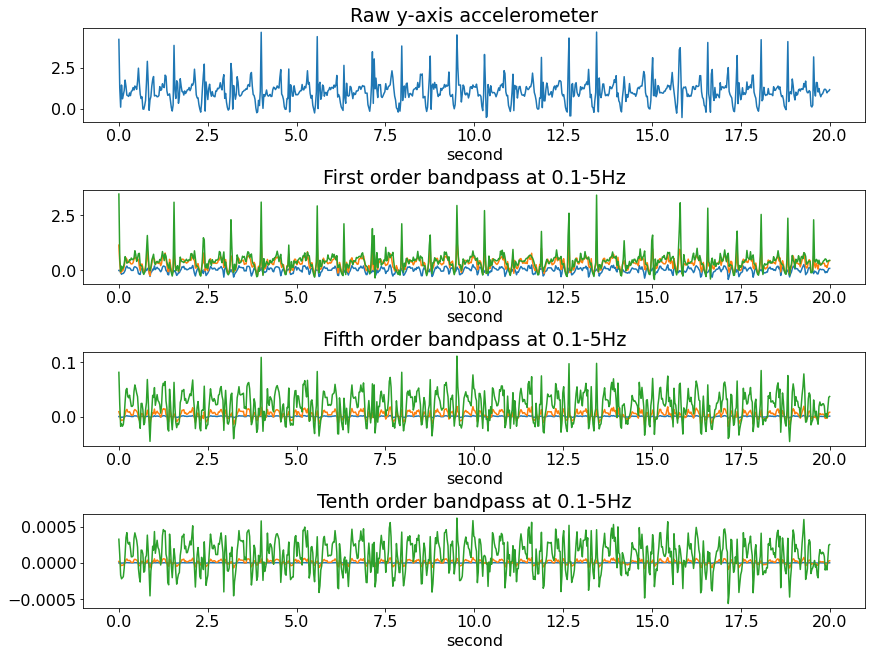

In [37]:
## Here we defined the relative time (i.e. convert index to seconds)
relative_time = np.linspace(0, 20, 20 * 40)

## Here we get the y-axis reading from accelerometer 
acc_sig = acc.y_raw

## TO DO: Fill in some filter codes 
first_order = butter_bandpass_filter(acc, .5, 5, 40, 1)
fifth_order = butter_bandpass_filter(acc, .5, 5, 40, 5)
tenth_order = butter_bandpass_filter(acc, .5, 5, 40, 10)

## This code generate a relatively nice 4*1 figure 
plt.figure(1)
plt.clf()
plt.rcParams['figure.figsize'] = [12, 9]
plt.rcParams['font.size'] = '16'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Tahoma']
fig, axs = plt.subplots(4, 1, constrained_layout=True)

# TO DO: Plot your raw signal
axs[0].plot(relative_time, acc_sig)
axs[0].set_xlabel('second')
axs[0].set_title('Raw y-axis accelerometer')

# TO DO: Plot your 1st order filtered signal
axs[1].plot(relative_time, first_order)
axs[1].set_xlabel('second')
axs[1].set_title('First order bandpass at 0.1-5Hz')

# To DO: Plot your 5th order filtered signal
axs[2].plot(relative_time, fifth_order)
axs[2].set_xlabel('second')
axs[2].set_title('Fifth order bandpass at 0.1-5Hz')

# TO DO: Plot your 10th order filtered signal 
axs[3].plot(relative_time, tenth_order)
axs[3].set_xlabel('second')
axs[3].set_title('Tenth order bandpass at 0.1-5Hz')


plt.show()

## Spectrogram

In [20]:
samplerate, sine_sweep = read('data/another_unknown_signal.wav')

/tmp/ipykernel_333039/3702190747.py:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplerate, sine_sweep = read('data/another_unknown_signal.wav')


### Method One: STFT

Text(0, 0.5, 'Frequency')

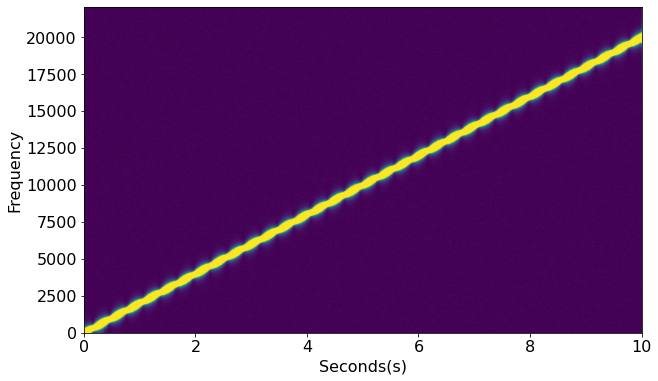

In [21]:
plt.rcParams['figure.figsize'] = [10, 6]

## nperseg = window size 
## noverlap = number of points that are overlapping
## For example: nperseg = 256, overlap = 128 -> 50% overlap 

f, t, Zxx = signal.stft(sine_sweep, samplerate, nperseg = 1024, noverlap = 0, return_onesided=True)
plt.pcolormesh(t, f, np.abs(Zxx), vmin=0, vmax=1.0, shading='gouraud')
plt.xlabel("Seconds(s)")
plt.ylabel("Frequency")

### Method Two: Spectrogram

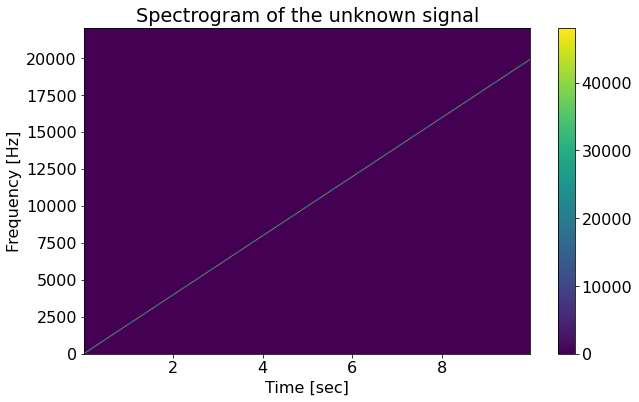

In [38]:
plt.rcParams["figure.figsize"] = (10, 6)

f, t, Sxx = signal.spectrogram(x = sine_sweep, fs=samplerate, nperseg=1024, noverlap=0)
c = plt.pcolormesh(t, f, np.abs(Sxx), shading = 'gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title("Spectrogram of the unknown signal")
plt.colorbar(c)
plt.show()

### <span style='color:Red'>Activity: Plot the Spectrogram with various FFT size and overlap</span>


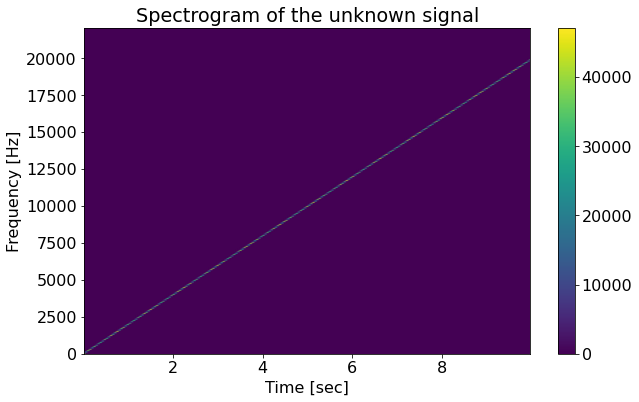

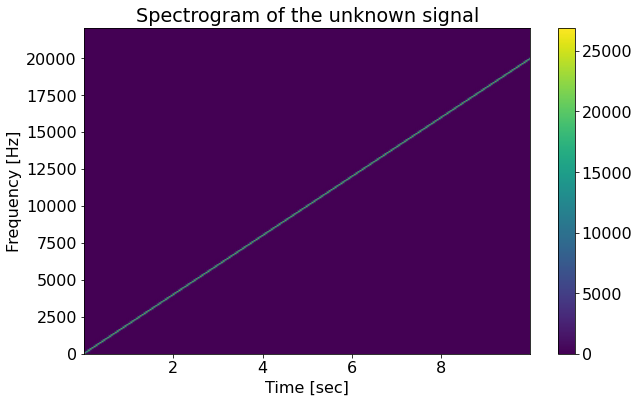

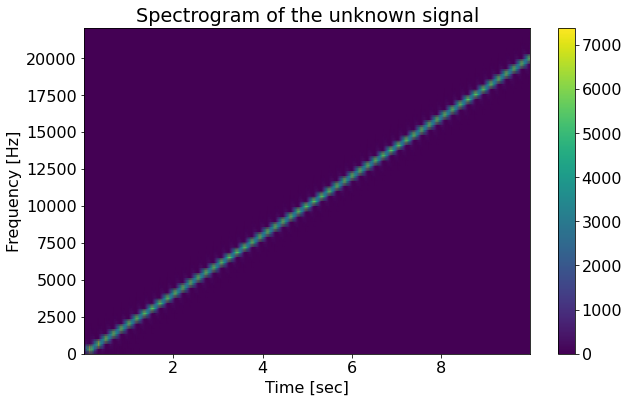

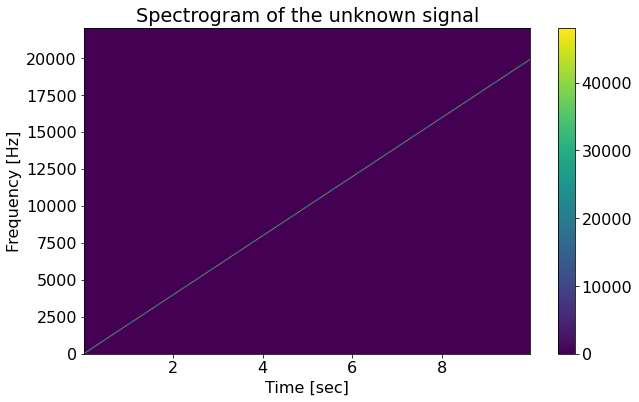

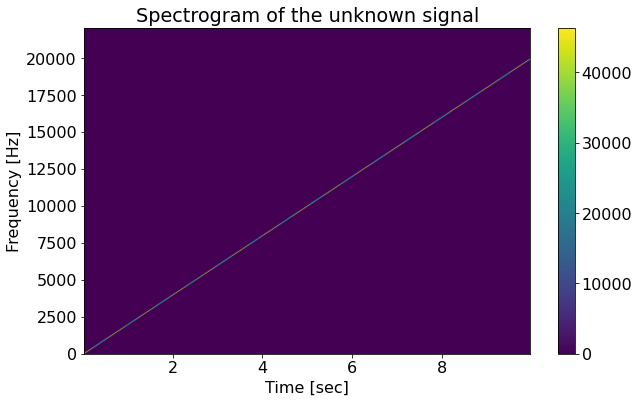

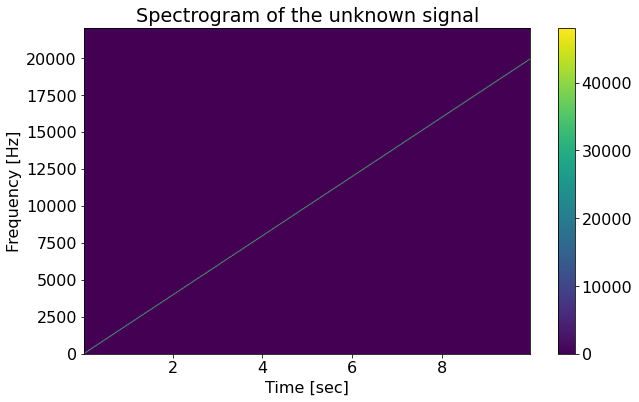

In [46]:
f, t, Sxx = signal.spectrogram(x = sine_sweep, fs=samplerate, nperseg=2048, noverlap=0)
c = plt.pcolormesh(t, f, np.abs(Sxx), shading = 'gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title("Spectrogram of the unknown signal")
plt.colorbar(c)
plt.show()

f, t, Sxx = signal.spectrogram(x = sine_sweep, fs=samplerate, nperseg=512, noverlap=0)
c = plt.pcolormesh(t, f, np.abs(Sxx), shading = 'gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title("Spectrogram of the unknown signal")
plt.colorbar(c)
plt.show()

f, t, Sxx = signal.spectrogram(x = sine_sweep, fs=samplerate, nperseg=128, noverlap=0)
c = plt.pcolormesh(t, f, np.abs(Sxx), shading = 'gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title("Spectrogram of the unknown signal")
plt.colorbar(c)
plt.show()

f, t, Sxx = signal.spectrogram(x = sine_sweep, fs=samplerate, nperseg=1024, noverlap=0)
c = plt.pcolormesh(t, f, np.abs(Sxx), shading = 'gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title("Spectrogram of the unknown signal")
plt.colorbar(c)
plt.show()

f, t, Sxx = signal.spectrogram(x = sine_sweep, fs=samplerate, nperseg=1024, noverlap=102)
c = plt.pcolormesh(t, f, np.abs(Sxx), shading = 'gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title("Spectrogram of the unknown signal")
plt.colorbar(c)
plt.show()

f, t, Sxx = signal.spectrogram(x = sine_sweep, fs=samplerate, nperseg=1024, noverlap=512)
c = plt.pcolormesh(t, f, np.abs(Sxx), shading = 'gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title("Spectrogram of the unknown signal")
plt.colorbar(c)
plt.show()

### <span style='color:Red'>Activity: Plot the Spectrogram for the accelerometer data</span>
